# **Analyzing NSW Public Transports Usage - Opal Cards' Tap-ons and Tap-offs**

## Problem Tasks: 

- Assess if **demographic data** (age group) has _direct and significant impacts_ on **public transport usage**. 

The dataset includes the _**total number of specified transportations to work by age** in ten-year groups_ in New South Wales taken from [the TableBuilder of the Australian Bureau of Statistics (ABS)](https://guest.censusdata.abs.gov.au/webapi/jsf/login.xhtml). 

**The census of Australian** was conducted in 2016, and the dataset was created and filtered from the census surveys of persons in usual residence areas across New South Wales, Australia. 

**Process:**
- Data preparation: 
    - Clean the dataset (transpose column to row, remove logo, title of organisation, etc.). 
    - Group the records into two major groups: under 60 (youth + workforce) years as class 0, over 60 (retiree) years as class 1.
- Data exploration: Plot graphs to compare transport usage of each broader age group to point out any direct relationshop between 2 factors.
- Model training: Logistic Regression, KNN, GaussianNB, and MLPClassifier.

**Goal:**
To study if **any of the predefined transport modes** could _predict a specific age group_, or whether _the working force choose train_ as the most convenient method of transport.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# Plot
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

# Functions used for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Functions used for K-Nearest Neighbours Classifier
from sklearn.neighbors import KNeighborsClassifier

# Functions used for Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Functions used for Neural Network
from sklearn.neural_network import MLPClassifier

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Import Data and Remove Texts 

As the dataset was taken **from the TableBuilder of the ABS**, we have to add modifications and convert it into an "_analysable_" format in the Notebook environment.

In [40]:
# Import data, skip the rows of logo and titles/names of the organisations
df = pd.read_excel("data/transportmodevsAge.xlsx", skiprows= 8, index_col =0)

# Set the first row as column names
df.columns = df.iloc[0]

# Remove the first two rows after setting it as column names (second row of NaN values and an header description)
df = df.iloc[2:]

# Remove several last rows of copyright, logo and sources
df = df[:5]

# Transpose columns and rows
df = df.T

# Remove several last rows of NaN values
age_total = df[12:13] # the index "Total"
df_age = df[:12] # not include index "Total"

# Rename columns
age_total.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]
df_age.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]

# Remove first row (transport title and NaN value)
df_age = df_age.iloc[1:]

# Final dataframe
df_age


,Train,Bus,Ferry,Tram,Total
AGE10P - Age in Ten Year Groups,,,,,
0-9 years,0,0,0,0,0
10-19 years,10869,8421,69,74,19431
20-29 years,115402,41592,1702,914,159610
30-39 years,114937,40941,3094,1077,160044
40-49 years,69864,28815,2617,722,102016
50-59 years,48007,19717,1522,452,69695
60-69 years,17732,7824,543,159,26257
70-79 years,1781,973,88,13,2855
80-89 years,166,92,4,0,265


### Removing Outliers

The statistics of the _0-9 and 100 years and over_ range are 0; therefore, we consider them as **outliers** and remove them from the dataframe. 

In [41]:
# Exclude outliers 
df_age = df_age[1:10]

### Replace the Total Column

Since there are several incorrect values in the "Total" field, we will re-calculate this field.

In [42]:
# Drop the Total column 
df_age.drop(["Total"], axis=1, inplace=True)

# Create new Total column
df_age["Total"] = df_age.Train + df_age.Bus + df_age.Ferry + df_age.Tram

# Preview new dataframe
df_age

,Train,Bus,Ferry,Tram,Total
AGE10P - Age in Ten Year Groups,,,,,
10-19 years,10869,8421,69,74,19433
20-29 years,115402,41592,1702,914,159610
30-39 years,114937,40941,3094,1077,160049
40-49 years,69864,28815,2617,722,102018
50-59 years,48007,19717,1522,452,69698
60-69 years,17732,7824,543,159,26258
70-79 years,1781,973,88,13,2855
80-89 years,166,92,4,0,262
90-99 years,20,13,0,0,33


### Group Age Ranges into Class

We divide all **11 age ranges** into _two classes of 0 and 1_:
- class 0: the youth and working force 
- class 1: the retiree group.

In [44]:
# Define function to classify age groups
def classify_age_group(age_group):
    youth_working_force = ["10-19 years", "20-29 years", "30-39 years", "40-49 years", "50-59 years"]
    return 0 if age_group in youth_working_force else 1

# Apply function to create Class column dynamically
df_age["Class"] = df_age.index.map(classify_age_group)

# Preview new dataframe
df_age

,Train,Bus,Ferry,Tram,Total,Class
AGE10P - Age in Ten Year Groups,,,,,,
10-19 years,10869,8421,69,74,19433,0
20-29 years,115402,41592,1702,914,159610,0
30-39 years,114937,40941,3094,1077,160049,0
40-49 years,69864,28815,2617,722,102018,0
50-59 years,48007,19717,1522,452,69698,0
60-69 years,17732,7824,543,159,26258,1
70-79 years,1781,973,88,13,2855,1
80-89 years,166,92,4,0,262,1
90-99 years,20,13,0,0,33,1


### Data Summary

In [45]:
# Dataframe dimension
df_age.shape

(9, 6)

In [ ]:
# Group by Class and sum transport mode columns
summary = df_age.groupby("Class")[["Train", "Bus", "Ferry", "Tram", "Total"]].sum()

# Display the summary
print(summary)  

        Train     Bus Ferry  Tram   Total
Class                                    
0      359079  139486  9004  3239  510808
1       19699    8902   635   172   29408


**Observations:**

1. Youth & Working Force (Class 0) Dominates Usage
- They make up the vast majority of transport users across all modes.
- Train usage is particularly high for this group (359,079), making it the most preferred transport option.

2. Retirees (Class 1) Have Significantly Lower Usage
- Their total transport usage (29,408) is much lower than Class 0 (510,888).
- Bus usage (8,902) is slightly higher than Ferry (635) and Tram (172), suggesting retirees may rely on buses more.

3. Train is the Most Used Transport Mode for Both Groups
- Even among retirees, the train (19,699) is used more than other modes.

## Data Exploration

Firstly, we plot a histogram of transport uses by each mode.

<AxesSubplot:>

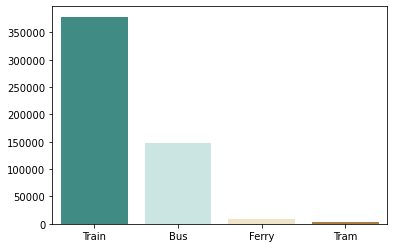

In [ ]:
mode_plot = age_total.drop(["Total"], axis=1)
sns.barplot(data= mode_plot, palette= "BrBG_r")

* ***Interpretation:*** It appears that Train service remains as the transport mode with the highest passengers across all age groups (378778 in total)

We also plot to find out how each age group uses all the transport modes.

In [75]:
agegr = df_age.drop(["Class", "Total"], axis=1)
agegr["Age Groups"] = agegr.index
agegr_melted = pd.melt(agegr, id_vars = "Age Groups", var_name="Transport Types")

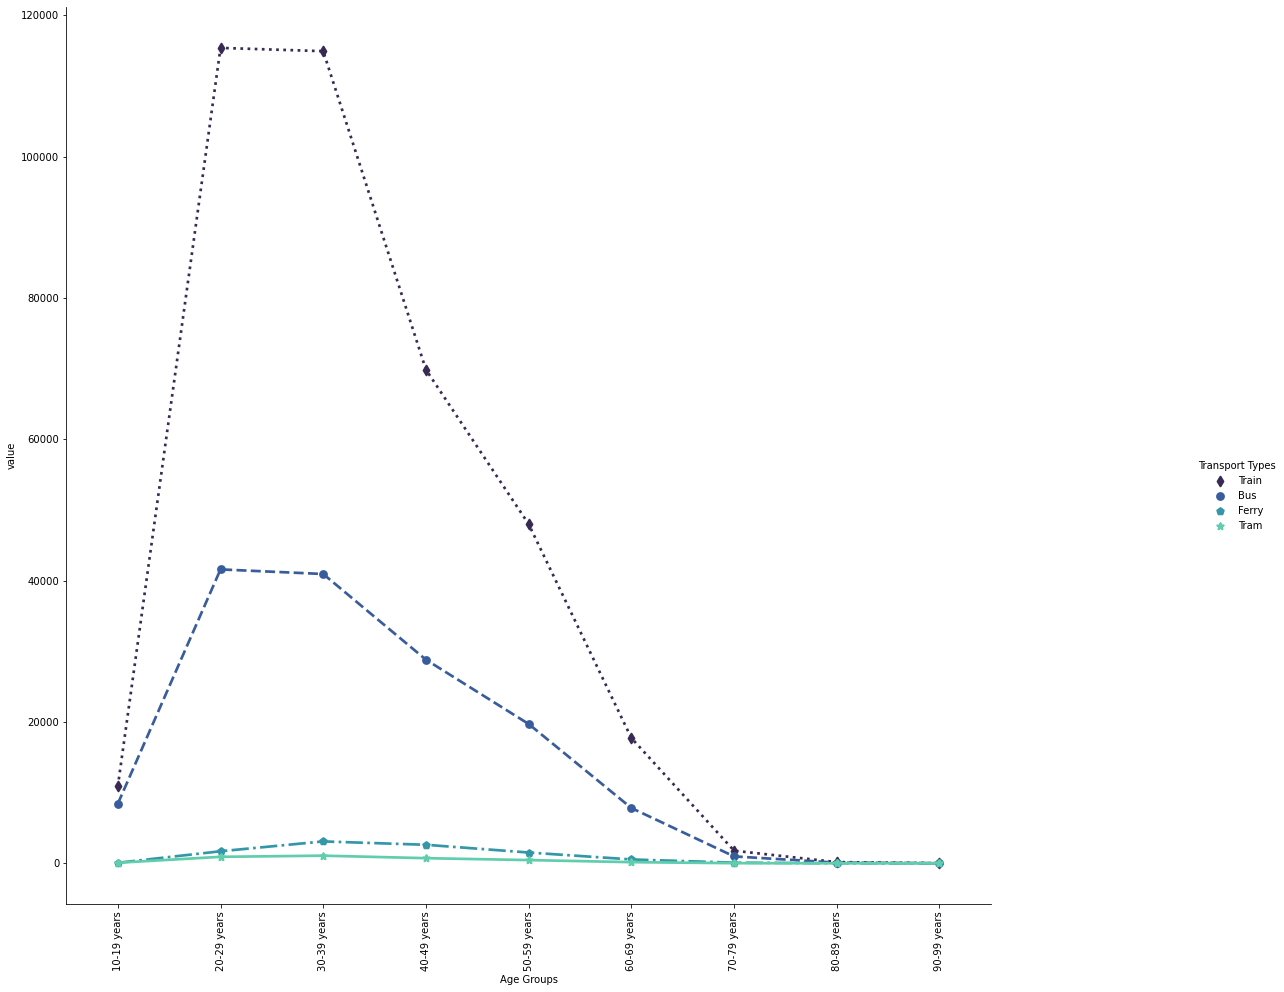

In [76]:
sns_plot = sns.catplot(x="Age Groups", y="value", markers=["d", "o", "p", "*"], 
                       linestyles=["dotted", "dashed", "dashdot", "solid"],
                       kind="point", hue= "Transport Types", data= agegr_melted,
                       palette = "mako")
sns_plot.fig.set_size_inches(20,14)
sns_plot.set_xticklabels(rotation = 90)

* ***Interpretation:*** overall, of all transport methods, the working force is the dominant group with the highest recorded number of travellings. 
   * Train service: Two age ranges 20-19 and 30-29 years reach aroung 115000 travellings while both the youth and retiree group are recorded with under 20000 passengers.
   * Bus service: Two age ranges 20-19 and 30-29 years remain as the groups with the most passengers (more than 40000). Similar to the train service, the retiree group has a lower uses of bus service with specificly 26257 for the 60-69 years range and under 3000 passengers for those aged above 70.
   * Ferry and Tram services: The uses of services just increases slightly and remains stable with two peaks at 30-39 and 40-49 years groups.

We also will plot to see the uses of each transport mode in percentage for each age range.

In [77]:
df_age["TRAIN"] = (df_age.Train*100)/df_age.Total
df_age["BUS"] = (df_age.Bus*100)/df_age.Total
df_age["FERRY"] = (df_age.Ferry*100)/df_age.Total
df_age["TRAM"] = (df_age.Tram*100)/df_age.Total
df_age.head(2)

,Train,Bus,Ferry,Tram,Total,Class,TRAIN,BUS,FERRY,TRAM
AGE10P - Age in Ten Year Groups,,,,,,,,,,
10-19 years,10869,8421,69,74,19433,0,55.930633,43.333505,0.355066,0.380796
20-29 years,115402,41592,1702,914,159610,0,72.302487,26.058518,1.066349,0.572646


<AxesSubplot:title={'center':'Percentage of Transport Uses'}, ylabel='Age Groups'>

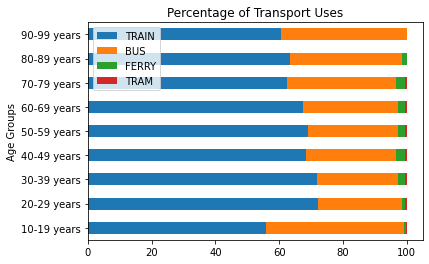

In [78]:
df = df_age.drop(["Train", "Bus", "Ferry", "Tram", "Total", "Class"], axis=1)
df['Age Groups'] = df.index
df.plot(x = "Age Groups", kind = 'barh', stacked = True, title = 'Percentage of Transport Uses')

* ***Interpretation:*** It is true as predicted that Train is the most popular among all age ranges. The working force seems to make the most use of train with roughly 70000 travellings for each age range of the working force while the figures of the other two groups are intermediately significant. Unlike working force, the youth and retiree groups use bus more often, especially youngsters aged from 10 to 19 years with more than 40% of all travellings. For ferry and tram, it appears that the percentage of these two transport modes use increase with age range and people who are older than 80 years old do not use ferry and tram.


Now we plot to see how the number of travellings of each age class varies. (Note that we have defined two classes).

<AxesSubplot:xlabel='Class', ylabel='Total'>

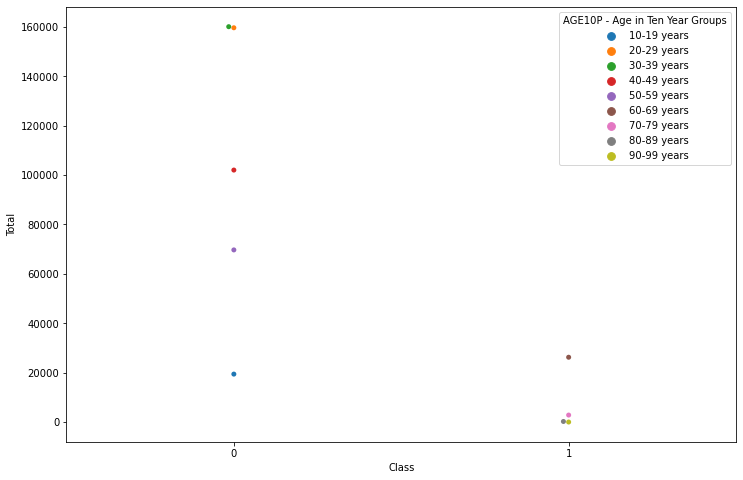

In [79]:
plt.figure(figsize=(12,8))
sns.swarmplot(x='Class', y='Total', data= df_age, hue= df_age.index)

* ***Interpretation:*** Similar to the plots for the number of travellings per age range and transport mode, class 0 as the youth and working force is recorded with the highest number of travellings of all transport modes with two peaks more than 160000. In contrast, statistics of class 1 is considerably lower with under 30000 travellings.

## Model Building 

In [80]:
df_age.drop(["TRAIN", "BUS", "FERRY", "TRAM"], axis= 1, inplace = True)

In [81]:
set(df_age['Class'])

{0, 1}

There are three classes: 
* 0 represents the youth and working force
* 1 represents the retiree

### Implement Losgistic Regression

Tran and Test sets splitting: 

In [82]:
# Split the data into training (50%) and testing data (50%) and use random_state is 7
train,test = train_test_split(df_age, test_size=0.5, random_state=7)
print(train.shape)
print(test.shape)

(4, 6)
(5, 6)


In [83]:
# Getting input data and targets for building prediction model:
X_train = train.drop(['Total', 'Class'], axis = 1)
y_train = train['Class']
X_test = test.drop(['Total', 'Class'], axis = 1)
y_test = test['Class']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print(X_train.head(2))
print(y_train.head(2))

X_train shape: (4, 4)
y_train shape: (4,)
X_test shape: (5, 4)
y_test shape: (5,)
                                 Train    Bus Ferry Tram
AGE10P - Age in Ten Year Groups                         
40-49 years                      69864  28815  2617  722
70-79 years                       1781    973    88   13
AGE10P - Age in Ten Year Groups
40-49 years    0
70-79 years    1
Name: Class, dtype: int64


In [84]:
# define the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [85]:
# Do predictions on test set
y_pred_train= model.predict(X_train)
y_pred_test= model.predict(X_test)
print(y_pred_train)
print(y_pred_test)

[0 1 0 0]
[0 1 1 1 1]


In [86]:
# Evaluate the performance of your trained model
print("Accuracy score on training test:", accuracy_score(y_train,y_pred_train))
print("Accuracy score on testing test:", accuracy_score(y_test,y_pred_test))

Accuracy score on training test: 1.0
Accuracy score on testing test: 0.8


In [87]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=7)

In [88]:
# list of accuracy score of test set
test_scores = []
test_scores.append(accuracy_score(y_test,y_pred_test))

* ***Comment:*** The accuracy scoreis 0.8 which is significantly high and suggests that the model was constructed well. However, it is possible that this model is overfitting due to the training accuracy score is 1.0 as a result of small dataset.

In [89]:
# Checking confusion metric 
print ("Confusion matrix on test set:")
print(confusion_matrix(y_test,y_pred_test))

Confusion matrix on test set:
[[1 1]
 [0 3]]


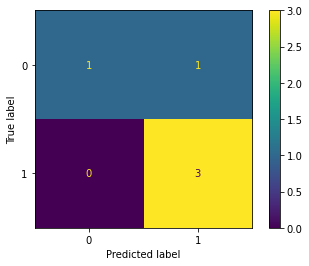

In [90]:
plot_confusion_matrix(model, X_test, y_test)

* ***Comment:*** The confusion matrix indicates 0 false negatives and 1 false positives, this resulting rate is acceptable and supports the significance of the model.

In [91]:
acc_scores = []
for i in range(1,5):
    clf = LogisticRegression(max_iter=1000)
    rfe = RFE(estimator =clf, n_features_to_select=i)
    #training model
    rfe.fit(X_train, y_train)
    #predicting on test set 
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print ("Acc on test set using", i, "feature: ", acc_score)
    print ("Feature which have been chosen:", X_train.columns[rfe.support_])
    print("")
    # append to the list 
    acc_scores.append(acc_score)

Acc on test set using 1 feature:  0.8
Feature which have been chosen: Index(['Bus'], dtype='object')

Acc on test set using 2 feature:  0.8
Feature which have been chosen: Index(['Train', 'Bus'], dtype='object')

Acc on test set using 3 feature:  0.8
Feature which have been chosen: Index(['Train', 'Bus', 'Ferry'], dtype='object')

Acc on test set using 4 feature:  0.8
Feature which have been chosen: Index(['Train', 'Bus', 'Ferry', 'Tram'], dtype='object')



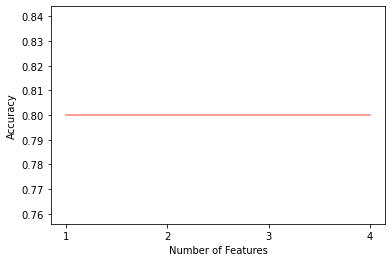

In [92]:
# Plotting the accuracy number
plotting = plt.plot(range(1, X_train.shape[1]+1), acc_scores, color= "salmon")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, 5 , step=1))
plt.show()

* ***Comment:*** RFE suggests that the accuracy remains the same for the selection of features. Therefore, we choose all four features to conduct a model and prevent the overfitting problem.

Cross Validation Testing

In [93]:
X= df_age.drop(["Total", "Class"], axis= 1)
y= df_age["Class"]

In [94]:
lr = LogisticRegression(max_iter=1000)
scores = cross_val_score(lr, X, y, scoring='accuracy', cv=3)
print('Accuracy range for Logistic Regression: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Logistic Regression: [0.6667, 1.0000]; mean: 0.7778; std: 0.1571



### K-Nearest Neighbours Classifier

Train and Test sets Splitting

In [95]:
# choosing the nearest 3 neighbours
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [96]:
# do prediction
train_pred = clf_knn.predict(X_train)
test_pred = clf_knn.predict(X_test)

In [97]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 0.75
Accuracy of the test set: 0.4


* ***Comment:*** Both accuracy scores of the train and test set is considerably lower than the result of Logistic Regression.

Cross Validation Testing

In [98]:
knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=2)
print('Accuracy range for K-Nearest Neighbours: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for K-Nearest Neighbours: [0.7500, 0.8000]; mean: 0.7750; std: 0.0250



### Gaussian Naive Bayes

Train and Test set splitting

In [99]:
# train the model
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)

GaussianNB()

In [100]:
# do prediction
train_pred = clf_gnb.predict(X_train)
test_pred = clf_gnb.predict(X_test)

In [101]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 1.0
Accuracy of the test set: 0.4


* ***Comment:*** The accuracy of the test set is the lowest of all three models that we have conducted so far while the accuracy of the train set reaches 1.0 which can indicate the a overfitting model.

Cross Validation Testing

In [102]:
gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, scoring='accuracy', cv=5)
print('Accuracy range for Gaussian Naive Bayes: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Gaussian Naive Bayes: [0.5000, 1.0000]; mean: 0.9000; std: 0.2000



* ***Comment:*** The mean accuracy score of the Gaussian Naive Bayes is significantly high with 0.9 after using the cross validation testing.

### Multi-layer Perceptron

Train and Test Sets Splitting

In [103]:
# train the model
clf_nn = MLPClassifier(max_iter=800,solver="lbfgs",activation="tanh",random_state=42)
clf_nn.fit(X_train, y_train)

MLPClassifier(activation='tanh', max_iter=800, random_state=42, solver='lbfgs')

In [104]:
# do prediction
train_pred = clf_nn.predict(X_train)
test_pred = clf_nn.predict(X_test)

In [105]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 1.0
Accuracy of the test set: 0.6


* ***Comment:*** The result is roughly the same as that of Gaussian Naives Bayes which also shows the possible overfitting problem.

Cross Validation Testing 

In [106]:
nn =  MLPClassifier(max_iter=800, solver="lbfgs",activation="tanh",random_state=42)
scores = cross_val_score(nn, X, y, scoring='accuracy', cv=4)
print('Accuracy range for Gaussian Naive Bayes: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Gaussian Naive Bayes: [0.6667, 1.0000]; mean: 0.9167; std: 0.1443



* ***Comment:*** The mean accuracy score is as high as the result of the Gaussian Naives Bayes model using cross validation test.

### Choosing the Best Model

In [107]:
# dataframe of accuracy scores
models = ["LR_Split", "LR_CV", "KNN_Split", "KNN_CV", "GNB_Split",
         "GNB_CV", "MLP_Split", "MLP_CV"]
df_acc = pd.DataFrame(models, columns=["Model Type"])
df_acc["Accuracy"] = test_scores

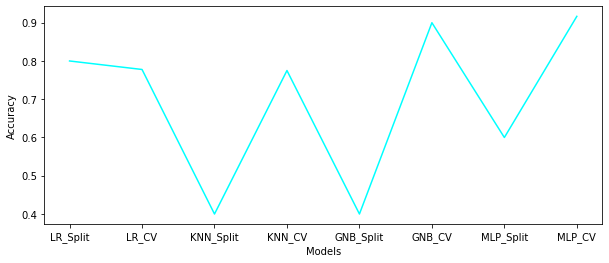

In [108]:
# Plotting the accuracy number
plt.figure (figsize = (10,4))
plt.plot(df_acc["Model Type"], df_acc["Accuracy"], color= "aqua")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

* ***Interpretation:*** Of all the models that we have conducted so far, it appears that the Logistics Regression model comes up with the most stable result with 0.8 and 0.78 for the train test splitting and cross validation testing respectively. In contrast, for the rest three models, the differences of the model results when conducting in two ways are considerably high which will refect the prediction well enough. Therefore, the Logistics Regression model should be applied to predict the age groups based on the transport uses.

## Conclusion

The age group dataset used in this section have to be modified carefully. Firstly we remove logo and title which we did the same for the second dataset. Then, we have to remove outliers since there are two groups with zero-records. Also, we have to recalculate the total field to minimise the incorrect data. The most noticeable feature in this dataset is that the size of the dataset is small, thus it may lead to the overfitting model.

We repeated the same data exploration steps as in the second dataset to discover the relationship between each age group and the uses of each transport service modes.

Since there are significant differences in the results of GNB, KNN and MLPClassifier models which might be due to the dataset size (affect on the constant train and test set using the split method), it is reasonable to not choose them as the best predicted result to avoid the overfitting and incorrect prediction. On the other hand, we will choose the Logistic Regression model which has the stable accuracy scores through two testing methods (train-test split and cross validation) to be the best learning result in this case (although it might not be very good model since the limited dataset size).